In [1]:
print('Load modules...')
import numpy as np
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary
from scipy.spatial.distance import cdist
from tqdm import tqdm
from collections import OrderedDict
# from models.vgg_cif10 import VGG
# from models.vgg import vgg16_bn
import argparse
import sklearn
import sklearn.covariance
from utils import get_network

import matplotlib.pyplot as plt
import pdb

from conf import settings

DATA_SPLIT = settings.DATA_SPLIT
IMAGE_SIZE = settings.IMAGE_SIZE
IMG_DIR    = settings.IMG_DIR
epsilon = settings.EPSILON

Load modules...


In [112]:
#processing the arguments
parser = argparse.ArgumentParser()
parser.add_argument("-attack", default='fgsm', help="the attack method which created the adversarial examples you want to use. Either fgsm, bim, pgd, df or cw")
parser.add_argument("-detector", default='InputPFS', help="the detector youz want to use, out of InputPFS, InputMFS, LayerMFS, LayerPFS, LID, Mahalanobis")
parser.add_argument("-net", default='resnet50', help="the network used for the attack, either resnet50")
parser.add_argument('-b', type=int, default=128, help='batch size for dataloader')
parser.add_argument('-gpu', action='store_true', default=True, help='use gpu or not')
parser.add_argument('-parallel', action='store_true', default=False, help='train on multiple GPUs training')

_StoreTrueAction(option_strings=['-parallel'], dest='parallel', nargs=0, const=True, default=False, type=None, choices=None, help='train on multiple GPUs training', metavar=None)

In [113]:
# args = parser.parse_args()

# print(args)

#choose attack
attack_method = 'fgsm' #args.attack
detector = 'InputPFS'  #args.detector
net = 'resnet50'       #args.net

b = str(128)

#load adversarials and their non-adversarial counterpart
print('Loading images and adversarial examples...')

root_dir = './data/' + IMAGE_SIZE + '_' + net + '_adversarial_images/'

epsilon = ''
if attack_method == 'fgsm' or attack_method == 'bim' or attack_method == 'pgd':
    epsilon = '_' + str(settings.EPSILON)

images = torch.load(root_dir + net + '_images_' + b + '_' + settings.DATA.lower() + '_' + attack_method + epsilon)
images_advs = torch.load(root_dir + net + '_images_adv_' + b + '_' + settings.DATA.lower() + '_' + attack_method + epsilon)

Loading images and adversarial examples...


In [114]:
number_images = len(images)
print('number_images: ', number_images)

number_images:  3407


In [115]:
from models.resnet import resnet50

# model.load_state_dict(torch.load(settings.CHECKPOINT_PATH))

In [116]:
model = resnet50(num_classes=2)

In [117]:
CHECKPOINT_PATH = './checkpoint/resnet50/32x32_128_0.1_Smiling_Wednesday_07_April_2021_17h_51m_22s/resnet50-121-best.pth'
model.load_state_dict(torch.load(CHECKPOINT_PATH))

<All keys matched successfully>

In [118]:
model = model.eval()
model = model.cuda()

In [119]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [120]:

model.conv1[2].register_forward_hook(get_activation('conv1_relu_2'))
model.conv2_x[0].residual_function[2].register_forward_hook(get_activation('conv2_0_relu_2'))
model.conv2_x[0].residual_function[5].register_forward_hook(get_activation('conv2_0_relu_5'))
model.conv2_x[1].residual_function[2].register_forward_hook(get_activation('conv2_1_relu_2'))
model.conv2_x[1].residual_function[3].register_forward_hook(get_activation('conv2_1_conv2d_3'))
model.conv2_x[1].residual_function[5].register_forward_hook(get_activation('conv2_1_relu_5'))
model.conv2_x[2].residual_function[2].register_forward_hook(get_activation('conv2_2_relu_2'))
model.conv2_x[2].residual_function[5].register_forward_hook(get_activation('conv2_2_relu_5'))

model.conv3_x[0].residual_function[2].register_forward_hook(get_activation('conv3_0_relu_2'))
model.conv3_x[0].residual_function[5].register_forward_hook(get_activation('conv3_0_relu_5'))
model.conv3_x[1].residual_function[2].register_forward_hook(get_activation('conv3_1_relu_2'))
model.conv3_x[1].residual_function[3].register_forward_hook(get_activation('conv3_1_conv2d_3'))
model.conv3_x[1].residual_function[5].register_forward_hook(get_activation('conv3_1_relu_5'))
model.conv3_x[2].residual_function[2].register_forward_hook(get_activation('conv3_2_relu_2'))
model.conv3_x[2].residual_function[5].register_forward_hook(get_activation('conv3_2_relu_5'))

model.conv4_x[0].residual_function[2].register_forward_hook(get_activation('conv4_0_relu_2'))
model.conv4_x[0].residual_function[5].register_forward_hook(get_activation('conv4_0_relu_5'))
model.conv4_x[1].residual_function[2].register_forward_hook(get_activation('conv4_1_relu_2'))
model.conv4_x[1].residual_function[3].register_forward_hook(get_activation('conv4_1_conv2d_3'))
model.conv4_x[1].residual_function[5].register_forward_hook(get_activation('conv4_1_relu_5'))
model.conv4_x[2].residual_function[2].register_forward_hook(get_activation('conv4_2_relu_2'))
model.conv4_x[2].residual_function[5].register_forward_hook(get_activation('conv4_2_relu_5'))

model.conv5_x[0].residual_function[2].register_forward_hook(get_activation('conv5_0_relu_2'))
model.conv5_x[0].residual_function[5].register_forward_hook(get_activation('conv5_0_relu_5'))
model.conv5_x[1].residual_function[2].register_forward_hook(get_activation('conv5_1_relu_2'))
model.conv5_x[1].residual_function[3].register_forward_hook(get_activation('conv5_1_conv2d_3'))
model.conv5_x[1].residual_function[5].register_forward_hook(get_activation('conv5_1_relu_5'))
model.conv5_x[2].residual_function[2].register_forward_hook(get_activation('conv5_2_relu_2'))
model.conv5_x[2].residual_function[5].register_forward_hook(get_activation('conv5_2_relu_5'))

model.avg_pool.register_forward_hook(get_activation('avg_pool'))
model.fc.register_forward_hook(get_activation('fc'))



In [121]:
data = images[0].unsqueeze_(0)
output = model(data)

In [122]:
output.shape

torch.Size([1, 2])

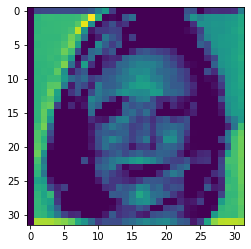

In [123]:
act = activation['conv1_relu_2'].squeeze()
plt.imshow(act[63].cpu())

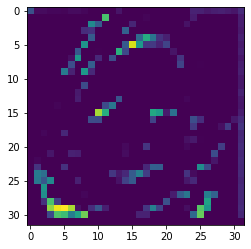

In [124]:
act = activation['conv2_0_relu_2'].squeeze()
plt.imshow(act[63].cpu())

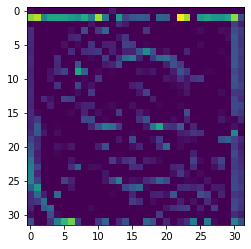

In [125]:
act = activation['conv2_2_relu_5'].squeeze()
plt.imshow(act[63].cpu())

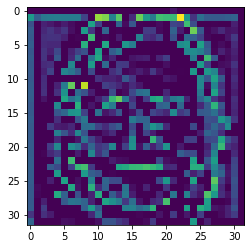

In [126]:
act = activation['conv3_0_relu_2'].squeeze()
plt.imshow(act[63].cpu())

torch.Size([1, 128, 16, 16])


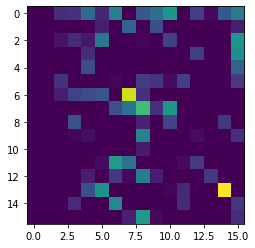

In [127]:
act = activation['conv3_2_relu_5']
print(act.shape)
act = act.squeeze()
plt.imshow(act[63].cpu())

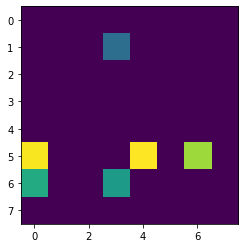

In [128]:
act = activation['conv4_2_relu_5'].squeeze()
plt.imshow(act[63].cpu())

In [129]:
act = activation['conv5_0_relu_2'].squeeze()


In [130]:
act.shape

torch.Size([512, 8, 8])

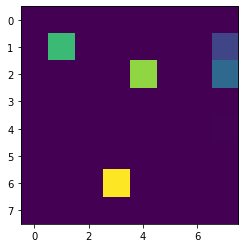

In [131]:
plt.imshow(act[63].cpu())

torch.Size([1, 64, 32, 32])


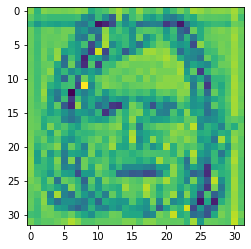

In [133]:
act = activation['conv2_1_conv2d_3']
print(act.shape)
act = act.squeeze()
plt.imshow(act[63].cpu())

torch.Size([1, 128, 16, 16])


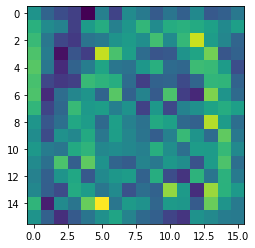

In [134]:
act = activation['conv3_1_conv2d_3']
print(act.shape)
act = act.squeeze()
plt.imshow(act[63].cpu())

torch.Size([1, 512, 4, 4])


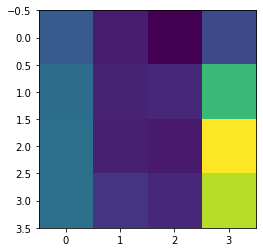

In [136]:
act = activation['conv5_1_conv2d_3']
print(act.shape)
act = act.squeeze()
plt.imshow(act[63].cpu())

In [14]:
img = np.load('./a.npy')

In [15]:
img.shape

(32, 32, 3)

In [16]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


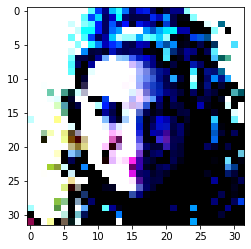

In [20]:
plt.imshow(img, cmap='gray')
plt.show()